In [1]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
tf = transforms.Compose([ToTensor(), transforms.Resize(16)])
mnist_train = datasets.MNIST('mnist_data/', download=True, train=True, transform=tf)
mnist_test = datasets.MNIST('mnist_data/', download=True, train=False, transform=tf)

In [3]:
targets = [0, 1, 2, 3, 4]
train_indices = [i for i, label in enumerate(mnist_train.targets) if label in targets]
mnist_train_s = Subset(mnist_train, train_indices)
test_indices = [i for i, label in enumerate(mnist_test.targets) if label in targets]
mnist_test_s = Subset(mnist_test, test_indices)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [5]:
train_set = torch.utils.data.DataLoader(mnist_train_s, batch_size=256, shuffle=True)
test_set = torch.utils.data.DataLoader(mnist_test_s, batch_size=256, shuffle=True)

In [6]:
img_size = 16
hidden_size = 16

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(img_size*img_size, hidden_size, bias=False),
            nn.ReLU(),
            #nn.Linear(hidden_size, hidden_size),
            #nn.ReLU(),
            nn.Linear(hidden_size, 5, bias=False),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


In [7]:
#model = NeuralNetwork().to(device)
model = torch.load('model_tiny.pth', map_location=torch.device(device))
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=256, out_features=16, bias=False)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=5, bias=False)
    (3): ReLU()
  )
)


In [8]:
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [9]:
from tqdm.notebook import tqdm

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #if batch % 100 == 0:
        #    loss, current = loss.item(), batch * len(X)
        #    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_set, model, loss_fn, optimizer)
    test_loop(test_set, model, loss_fn)
print("Done!")

In [ ]:
torch.save(model, 'model_tiny.pth')

In [10]:
imgs, labs = next(iter(test_set))

torch.Size([256, 1, 16, 16]) torch.Size([256])
tensor(2) tensor(2)


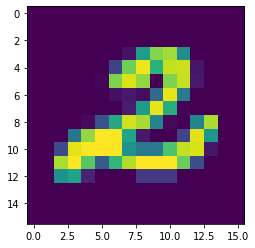

In [16]:
import random
idx = random.randint(0, len(imgs))
print(imgs.shape, labs.shape)
plt.imshow(imgs[idx].squeeze())
pred = model(imgs[idx].to(device))
print(torch.argmax(pred.cpu()), labs[idx])

In [ ]:
tf = transforms.Compose([
    ToTensor(), 
    transforms.CenterCrop(240), 
    transforms.Resize(16), 
    lambda x: transforms.functional.rotate(x, 180)
])
custom_test = datasets.ImageFolder('custom_data/', transform=tf)

In [ ]:
img, lab = custom_test[0]
print(lab)
t1 = img.sum(dim=0, keepdim=True)
t1 = torch.where(t1 < 2, 1., 0.)
print(t1.shape)
plt.imshow(t1.squeeze(), cmap='gray')

In [ ]:
pred = model(t1.to(device))
print(torch.argmax(pred.cpu()))

In [17]:
print(model)
print(model.linear_relu_stack[0].weight.detach().cpu().numpy())

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=256, out_features=16, bias=False)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=5, bias=False)
    (3): ReLU()
  )
)
[[-0.02995802  0.06048698 -0.00294643 ... -0.03840897  0.01597941
   0.02413949]
 [ 0.03751167  0.00200884  0.03952006 ...  0.01479991 -0.04873639
   0.04989079]
 [ 0.01449017  0.04358295  0.02053194 ...  0.01248768 -0.01249415
   0.00027586]
 ...
 [-0.00084087  0.00154165 -0.04981082 ... -0.0161896   0.01437821
   0.01331058]
 [-0.03228867 -0.00982332 -0.03382243 ... -0.01653415 -0.00767311
  -0.04889172]
 [ 0.00249162 -0.03335837  0.04968004 ...  0.01078875 -0.04722018
  -0.01703155]]


In [18]:
def get_weight(m, idx):
    return m.linear_relu_stack[idx*2].weight.detach().cpu().numpy()
def get_bias(m, idx):
    return m.linear_relu_stack[idx*2].bias.detach().cpu().numpy()
def to_fixed_point(mat):
    return (mat * (2**8)).round().astype(int).tolist()

In [24]:
w0, w2 = get_weight(model, 0), get_weight(model, 1)
print(w0, w2)

[[-0.02995802  0.06048698 -0.00294643 ... -0.03840897  0.01597941
   0.02413949]
 [ 0.03751167  0.00200884  0.03952006 ...  0.01479991 -0.04873639
   0.04989079]
 [ 0.01449017  0.04358295  0.02053194 ...  0.01248768 -0.01249415
   0.00027586]
 ...
 [-0.00084087  0.00154165 -0.04981082 ... -0.0161896   0.01437821
   0.01331058]
 [-0.03228867 -0.00982332 -0.03382243 ... -0.01653415 -0.00767311
  -0.04889172]
 [ 0.00249162 -0.03335837  0.04968004 ...  0.01078875 -0.04722018
  -0.01703155]] [[ 0.00373369 -0.02543828 -0.40735474  0.04673827  0.6668399  -0.43122718
  -0.12547009  0.28622603  0.56506217  0.37653485 -0.30774966 -0.41526785
   0.52607894 -0.5035312   0.43840837 -0.2418123 ]
 [-0.38885352  0.07678976 -0.3574415   0.4109099  -0.19175442  0.67773956
   0.19241878 -0.09831495 -0.5199163   0.05001806  0.0505731   0.46042225
  -0.27061242  0.7671012   0.47709307  0.0838061 ]
 [ 0.5008487  -0.04207736  0.23432647 -0.29853162  0.56746215 -0.31039646
  -0.07153106 -0.04336998  0.0061712

In [26]:
print(w2.tolist())

[[0.003733687102794647, -0.025438277050852776, -0.4073547422885895, 0.04673827067017555, 0.6668398976325989, -0.4312271773815155, -0.1254700869321823, 0.2862260341644287, 0.5650621652603149, 0.3765348494052887, -0.3077496588230133, -0.41526785492897034, 0.5260789394378662, -0.5035312175750732, 0.43840837478637695, -0.2418123036623001], [-0.388853520154953, 0.07678975909948349, -0.3574415147304535, 0.41090989112854004, -0.19175441563129425, 0.6777395606040955, 0.19241878390312195, -0.09831494837999344, -0.519916296005249, 0.0500180646777153, 0.05057310312986374, 0.46042224764823914, -0.2706124186515808, 0.7671012282371521, 0.47709307074546814, 0.0838061049580574], [0.5008487105369568, -0.042077355086803436, 0.23432646691799164, -0.2985316216945648, 0.567462146282196, -0.3103964626789093, -0.07153106480836868, -0.04336997866630554, 0.006171196699142456, 0.4087165594100952, 0.23078688979148865, 0.3163265883922577, -0.36310189962387085, 0.5760086178779602, -0.3053487539291382, 0.0922531336

In [21]:
print(to_fixed_point(w2))

[[1, -7, -104, 12, 171, -110, -32, 73, 145, 96, -79, -106, 135, -129, 112, -62], [-100, 20, -92, 105, -49, 174, 49, -25, -133, 13, 13, 118, -69, 196, 122, 21], [128, -11, 60, -76, 145, -79, -18, -11, 2, 105, 59, 81, -93, 147, -78, 24], [-76, -36, -111, -4, 147, 180, 1, -31, 128, -108, -50, 52, 75, -36, -58, 58], [-93, 20, 231, -7, -171, -42, 7, 14, 156, 1, -12, -45, 112, 42, 68, 85]]


In [ ]:
tw0, tb0 = torch.rand(4, 5), torch.rand(4)

In [ ]:
tw1, tb1 = torch.rand(4, 4), torch.rand(4)

In [ ]:
tw2, tb2 = torch.rand(2, 4), torch.rand(2)

In [ ]:
print(to_fixed_point(tw0.numpy()), to_fixed_point(tb0.numpy()))
print(to_fixed_point(tw1.numpy()), to_fixed_point(tb1.numpy()))
print(to_fixed_point(tw2.numpy()), to_fixed_point(tb2.numpy()))

In [ ]:
tx1, tx2 = torch.rand(5,), torch.rand(5,)

In [ ]:
print(to_fixed_point(tx1.numpy()), to_fixed_point(tx2.numpy()))

In [ ]:
from torch.nn.functional import relu
ty1 = relu(tw2.matmul(relu(tw1.matmul(relu(tw0.matmul(tx1) + tb0)) + tb1)) + tb2)
ty2 = relu(tw2.matmul(relu(tw1.matmul(relu(tw0.matmul(tx2) + tb0)) + tb1)) + tb2)

In [ ]:
print(to_fixed_point(ty1.numpy()), to_fixed_point(ty2.numpy()))

In [ ]:
def approximate(mat):
    tmp = mat * (2**16) 
    return tmp.round() / (2**16)
def approximate_t(mat):
    tmp = mat * (2**16) 
    return tmp.floor() / (2**16)

In [ ]:
tw0r, tb0r = approximate(tw0), approximate(tb0)
tw1r, tb1r = approximate(tw1), approximate(tb1)
tw2r, tb2r = approximate(tw2), approximate(tb2)
tx1r, tx2r = approximate(tx1), approximate(tx2)

In [ ]:
ty1r = relu(approximate_t(tw2r.matmul(relu(approximate_t(tw1r.matmul(relu(approximate_t(tw0r.matmul(tx1r)) + tb0r))) + tb1r))) + tb2r)
ty2r = relu(approximate_t(tw2r.matmul(relu(approximate_t(tw1r.matmul(relu(approximate_t(tw0r.matmul(tx2r)) + tb0r))) + tb1r))) + tb2r)
print(to_fixed_point(ty1r.numpy()), to_fixed_point(ty2r.numpy()))

In [ ]:
print(to_fixed_point(relu(approximate_t(tw2r.matmul(relu(approximate_t(tw1r.matmul(relu(approximate_t(tw0r.matmul(tx1r)) + tb0r))) + tb1r))) + tb2r).numpy()))